In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_2dm as fresnel
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

# reload(utils)
# wfe = utils.generate_wfe(diam=pupil_diam, npix=512, oversample=1,
#                          opd_index=2.5, amp_index=2.5, 
#                          opd_seed=12, amp_seed=34,
#                          opd_rms=15*u.nm, amp_rms=0.05, 
#                          wavelength=wavelength_c)

# TELE_WFE = poppy.ArrayOpticalElement(name='WFE', 
#                                      transmission=xp.abs(wfe),
#                                      opd=xp.angle(wfe)*wavelength_c.to_value(u.m)/(2*np.pi), 
#                                      pixelscale=pupil_diam/(512*u.pix),)

# wfe_mask = TELE_WFE.amplitude>0
# rms_amp = xp.sqrt(xp.mean(TELE_WFE.amplitude[wfe_mask]**2))
# rms_opd = xp.sqrt(xp.mean(TELE_WFE.opd[wfe_mask]**2))
# imshow2(TELE_WFE.amplitude, TELE_WFE.opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Propagating wavelength 650.000 nm.
PSF calculated in 0.339s
0.0003123167080856787


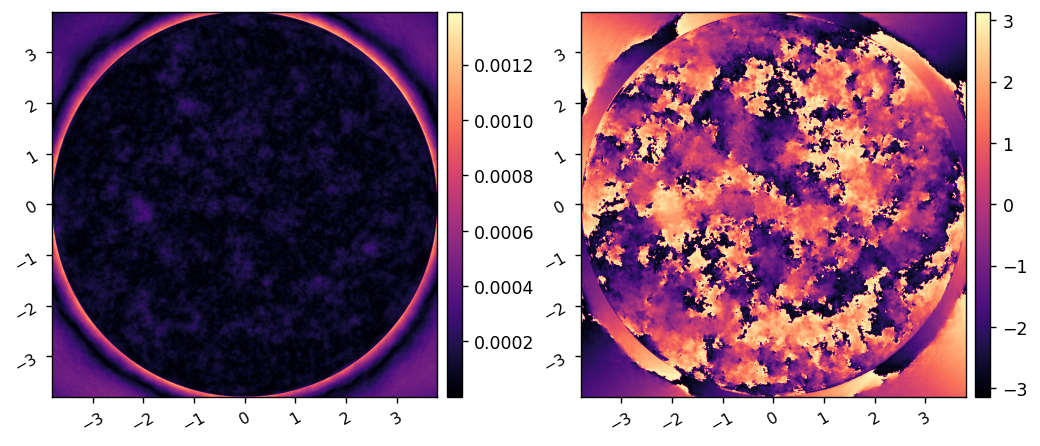

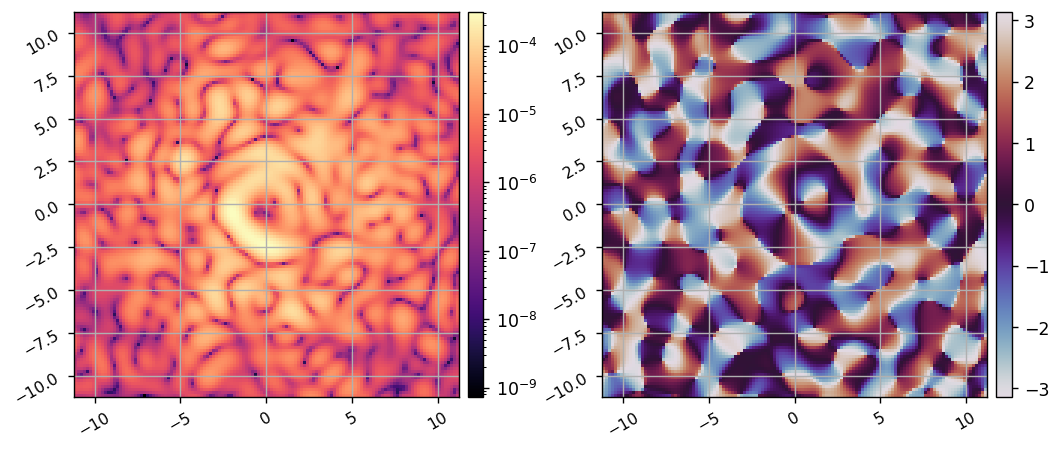

In [17]:
reload(fresnel)
poppy_log.disabled = True

coro = fresnel.CORO()
coro.Imax_ref = 0.01867821

coro.use_opds = True
coro.Imax_ref = 0.01795029

# pup_ratio = coro.pupil_diam.to_value(u.m)/coro.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-coro.Nact//2, coro.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# coro.set_dm1(ensure_np_array(comm1))
# coro.set_dm2(ensure_np_array(comm2))

coro.use_fpm = True

# fpwf = coro.calc_wf()
# im = xp.abs(fpwf)**2
# imshow2(im, xp.angle(fpwf), lognorm1=True, vmin1=xp.max(im)/1e5, cmap2='twilight', 
#         pxscl=coro.psf_pixelscale_lamD, grid=True, 
#         patches1=[Circle((coro.psf_pixelscale_lamD/2,coro.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])

wfs = coro.calc_wfs()
print(xp.max(wfs[-1].intensity))
imshow2(wfs[-10].amplitude, wfs[-10].phase, pxscl=wfs[-10].pixelscale.to(u.mm/u.pix), npix=coro.npix)
imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, cmap2='twilight', pxscl=coro.psf_pixelscale_lamD, grid=True)



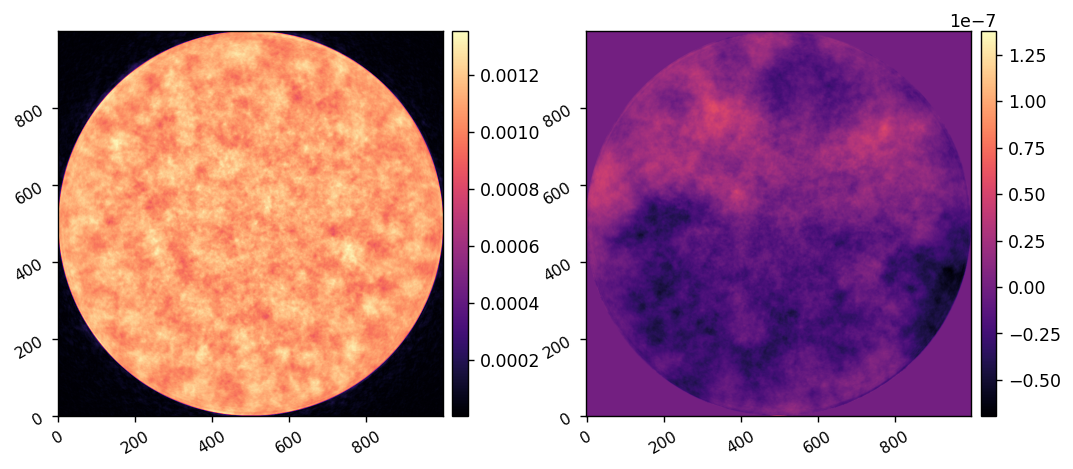

Saved data to:  ../phase-retrieval-data/post_fpm_wfe_20240503.fits


In [15]:
wf_index = -10
amp = utils.pad_or_crop(wfs[wf_index].amplitude, coro.npix)
opd = utils.pad_or_crop(wfs[wf_index].phase * coro.wavelength.to_value(u.m)/(2*np.pi), coro.npix)
opd *= coro.APERTURE.amplitude
imshow2(amp, opd)
wfe = xp.array([amp,opd])

apra_pop_models.utils.save_fits('../phase-retrieval-data/post_fpm_wfe_20240503.fits', wfe,)


In [ ]:
for i,wf in enumerate(wfs[:-1]):
    if 'FPM' in wf.location:
        npix=128
    elif 'Lyot' in wf.location:
        npix=coro.npix
    else:
        npix=coro.npix
    print(wf.w_0, wf.z_r)
    imshow2(wf.amplitude, wf.phase, f'{i:d}, '+wf.location, 
            npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix),
            cmap1='magma', cmap2='twilight')

imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True, pxscl=coro.psf_pixelscale_lamD, cmap2='twilight')